In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from itertools import combinations
from scipy.stats import mannwhitneyu
import warnings

import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu
from peregrin.scripts import PlotParams
import seaborn as sns
from itertools import combinations
import altair as alt
import plotly.graph_objects as go





In [127]:
warnings.simplefilter("ignore", FutureWarning)

In [128]:
spot_df_intconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats 2025-09-07 conds-int.csv")
spot_df_strconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats 2025-09-07 conds-str.csv")
track_df_intconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track stats 2025-09-07 conds-int.csv")
track_df_strconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track stats 2025-09-07 conds-str.csv")

In [129]:
def _generate_random_color():
    """
    Generate a random color in hexadecimal format.

    """

    r = np.random.randint(0, 255)   # Red LED intensity
    g = np.random.randint(0, 255)   # Green LED intensity
    b = np.random.randint(0, 255)   # Blue LED intensity

    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def _generate_random_grey():
    """
    Generate a random grey color in hexadecimal format.

    """

    n = np.random.randint(0, 240)  # All LED intensities

    return '#{:02x}{:02x}{:02x}'.format(n, n, n)

def _make_cmap(elements, cmap):
    """
    Generate a qualitative colormap for a given list of elements.

    """

    n = len(elements)   # Number of elements in the dictionary
    if n == 0:          # Return an empty list if there are no elements
        return []       
    
    cmap = plt.get_cmap(cmap)                                   # Get the colormap
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]    # Generate a color for each element

    return colors

def _get_cmap(c_mode):
    """
    Get a colormap according to the selected color mode.

    """

    if c_mode == 'greyscale LUT':
        return plt.cm.gist_yarg
    elif c_mode == 'jet LUT':
        return plt.cm.jet
    elif c_mode == 'brg LUT':
        return plt.cm.brg
    elif c_mode == 'hot LUT':
        return plt.cm.hot
    elif c_mode == 'gnuplot LUT':
        return plt.cm.gnuplot
    elif c_mode == 'viridis LUT':
        return plt.cm.viridis
    elif c_mode == 'rainbow LUT':
        return plt.cm.rainbow
    elif c_mode == 'turbo LUT':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral LUT':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar LUT':
        return plt.cm.gist_ncar
    else:
        return None


In [130]:
def index_uid(df):
    grp = df.groupby(['Condition', 'Replicate', 'Track ID'], sort=False)

    # ---- Add unique per-track index (1-based) ----
    df['Track UID'] = grp.ngroup()
    df.set_index(['Track UID'], drop=True, append=False, inplace=True, verify_integrity=False)

Spot_df =index_uid(spot_df_intconds)

In [131]:
for idx in spot_df_intconds.index.unique():
    print(spot_df_intconds.loc[idx])
    break

           Track ID  Time point  X coordinate  Y coordinate  Condition  \
Track UID                                                                
0               0.0         0.0         81.90        664.95          1   
0               0.0       120.0         81.90        664.95          1   
0               0.0       240.0         82.55        664.95          1   
0               0.0       360.0         82.55        664.95          1   
0               0.0       480.0         81.25        664.95          1   
...             ...         ...           ...           ...        ...   
0               0.0     10320.0         79.30        664.95          1   
0               0.0     10440.0         79.30        664.95          1   
0               0.0     10560.0         79.30        664.95          1   
0               0.0     10680.0         79.30        664.95          1   
0               0.0     10800.0         79.30        664.95          1   

           Replicate  Distance  Direc

In [132]:
def Visualize_tracks_matplotlib(
        Spots_df: pd.DataFrame, 
        Tracks_df: pd.DataFrame, 
        *args,
        condition: str = 'all', 
        replicate: str = 'all',
        c_mode: str = 'random colors', 
        only_one_color: str = 'blue', 
        lut_scaling_metric: str = 'Track displacement', 
        background: str = 'dark', 
        smoothing_index: float = 0.0, 
        lw: float = 1.0, 
        show_tracks: bool = True, 
        grid: bool = True, 
        arrows: bool = False, 
        arrowsize: int = 1
        ):

    if show_tracks:
        pass
    else:
        lw=0

    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()


    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass


    sort_cols = ['Condition', 'Replicate', 'Track ID', 'Time point']
    missing_cols = [col for col in sort_cols if col not in Spots.columns]
    if not missing_cols:
        if condition == 'all':
            Spots = Spots.sort_values(by=sort_cols)
        elif condition != 'all' and replicate == 'all':
            Spots = Spots[Spots['Condition'] == condition].sort_values(by=sort_cols)
        elif condition != 'all' and replicate != 'all':
            Spots = Spots[(Spots['Condition'] == condition) & (Spots['Replicate'] == replicate)].sort_values(by=sort_cols)
    else:
        return plt.gcf()
    


    if background =='light':
        grid_color = 'gainsboro'
        face_color = 'white'
        grid_alpha = 0.5
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'
    else:
        grid_color = 'silver'
        face_color = 'darkgrey'
        grid_alpha = 0.75
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'
    

    np.random.seed(42)  # For reproducibility

    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        colormap = None

        if c_mode in ['random colors']:
            track_colors = [_generate_random_color() for _ in range(len(Tracks.index.unique()))]
        elif c_mode in ['random greys']:
            track_colors = [_generate_random_grey() for _ in range(len(Tracks.index.unique()))]
        # else:
        #     track_colors = [only_one_color for _ in range(len(Tracks.index.unique()))]
        
        Tracks['Track color'] = Tracks.index.map(dict(zip(Tracks.index.unique(), track_colors)))

    elif c_mode in ['differentiate conditions', 'differentiate replicates']:

        if c_mode == 'differentiate conditions':
            colormap = plt.get_cmap('Set1')  # TODO: Let the user define their q cmap
            unique_vals = Tracks['Condition'].unique()
            val_column = 'Condition'
        else:
            colormap = plt.get_cmap('Set1')
            unique_vals = Tracks["Replicate"].unique()
            print(unique_vals)
            val_column = 'Replicate'

        # Assign colors to each unique category
        val_to_color = {
            val: colormap(i % colormap.N)  # Wrap around if more values than colors
            for i, val in enumerate(sorted(unique_vals))
        }
        # Map those colors to the tracks
        Tracks['Track color'] = Tracks[val_column].map(val_to_color)

    else:
        
        colormap = _get_cmap(c_mode)
        metric_min = Tracks[lut_scaling_metric].min()
        metric_max = Tracks[lut_scaling_metric].max()


    fig, ax = plt.subplots(figsize=(13, 10))

    x_min = Spots['X coordinate'].min()
    x_max = Spots['X coordinate'].max()
    y_min = Spots['Y coordinate'].min()
    y_max = Spots['Y coordinate'].max()
    print(Spots)

    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X coordinate [microns]')
    ax.set_ylabel('Y coordinate [microns]')
    ax.set_title('Track Visualization', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(True, which='both', axis='both', color=grid_color, linestyle=grid_lines, linewidth=1, alpha=grid_alpha)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=8)


    # Spots_grouped = Spots_df.groupby(['Condition', 'Replicate', 'Track ID'])
    # Tracks_df.set_index(['Condition', 'Replicate', 'Track ID'], inplace=True)

    # fig = go.Figure()

    for idx in Spots.index.unique():
        """
        - group_keys is a tuple like: ('Condition_A', 'Rep1', 'Track_001')
        - group_df is the actual dataframe for that group
        
        """

        track_row = Tracks.iloc[idx]
        group_df = Spots.loc[idx].copy()
        # track_row['Condition'] = cond
        # track_row['Replicate'] = repl
        # track_row['Track ID'] = track


        if colormap is not None and c_mode in ['differentiate conditions', 'differentiate replicates']:
            key = track_row[val_column]  # val_column is either 'Condition' or 'Replicate'
            color = colormap(unique_vals.tolist().index(key) % colormap.N)  # consistent mapping
            group_df['Track color'] = mcolors.to_hex(color)
            
        elif colormap is not None:
            # This is for metric-based color mapping (quantitative)
            norm = plt.Normalize(metric_min, metric_max)
            color = colormap(norm(track_row[lut_scaling_metric]))
            group_df['Track color'] = mcolors.to_hex(color)

        elif c_mode in ['random colors', 'random greys']:
            group_df['Track color'] = track_row['Track color']

        elif c_mode == 'only-one-color':
            group_df['Track color'] = only_one_color


        if (type(smoothing_index) is int or type(smoothing_index) is float) and smoothing_index > 1:
            group_df['X coordinate'] = group_df['X coordinate'].rolling(window=smoothing_index, min_periods=1).mean()
            group_df['Y coordinate'] = group_df['Y coordinate'].rolling(window=smoothing_index, min_periods=1).mean()
        else:
            # group_df['X coordinate'] = group_df['X coordinate']
            # group_df['Y coordinate'] = group_df['Y coordinate']
            pass

        ax.plot(group_df['X coordinate'], group_df['Y coordinate'], color=group_df['Track color'].iloc[0], linewidth=lw)


        if len(group_df['X coordinate']) > 1 & arrows:
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(track_row['Direction mean (rad)'])  # Change in x based on angle
            dy = np.sin(track_row['Direction mean (rad)'])  # Change in y based on angle

            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(group_df['X coordinate'].iloc[-2], group_df['Y coordinate'].iloc[-2]),  # Start position (second-to-last point)
                posB=(group_df['X coordinate'].iloc[-2] + dx, group_df['Y coordinate'].iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=group_df['Track color'].iloc[0],  # Set the color of the arrow
                mutation_scale=arrowsize,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.2,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)


    # Tracks_df.reset_index(drop=False, inplace=True)

    return plt.gcf()


           Track ID  Time point  X coordinate  Y coordinate  Condition  \
Track UID                                                                
868             0.0         0.0        542.75        657.80          2   
868             0.0       120.0        547.95        658.45          2   
868             0.0       240.0        553.80        657.15          2   
868             0.0       360.0        555.75        659.75          2   
868             0.0       480.0        562.90        660.40          2   
...             ...         ...           ...           ...        ...   
1919          505.0     10800.0         71.50        419.90          2   
1920          506.0     10680.0        586.30        405.60          2   
1920          506.0     10800.0        586.30        406.25          2   
1921          507.0     10680.0        400.40        325.00          2   
1921          507.0     10800.0        404.95        326.95          2   

           Replicate  Distance  Direc

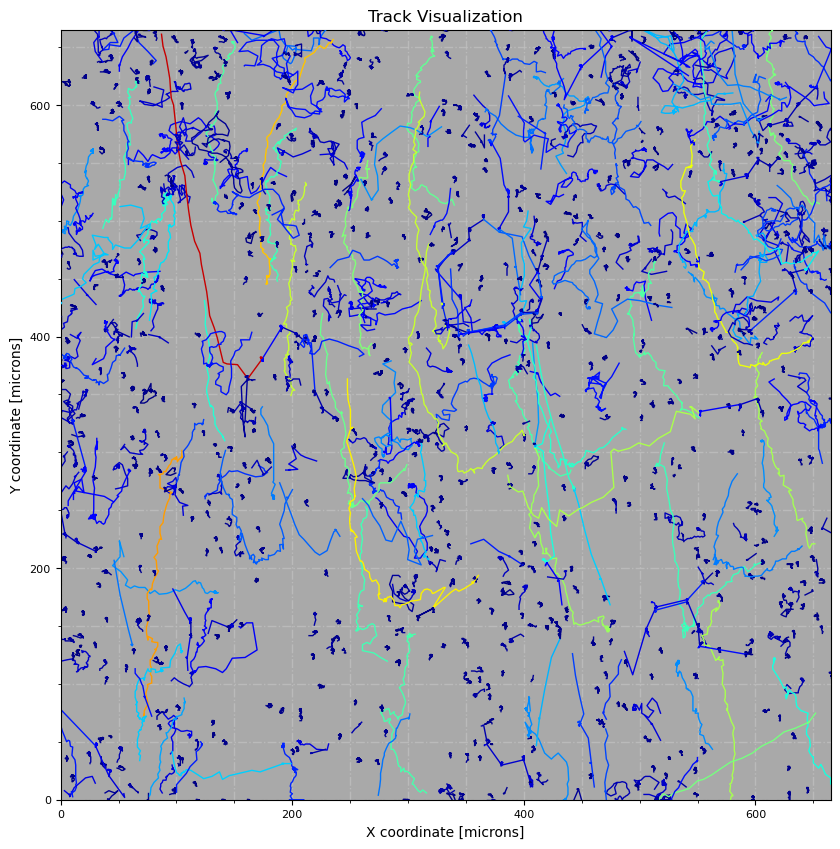

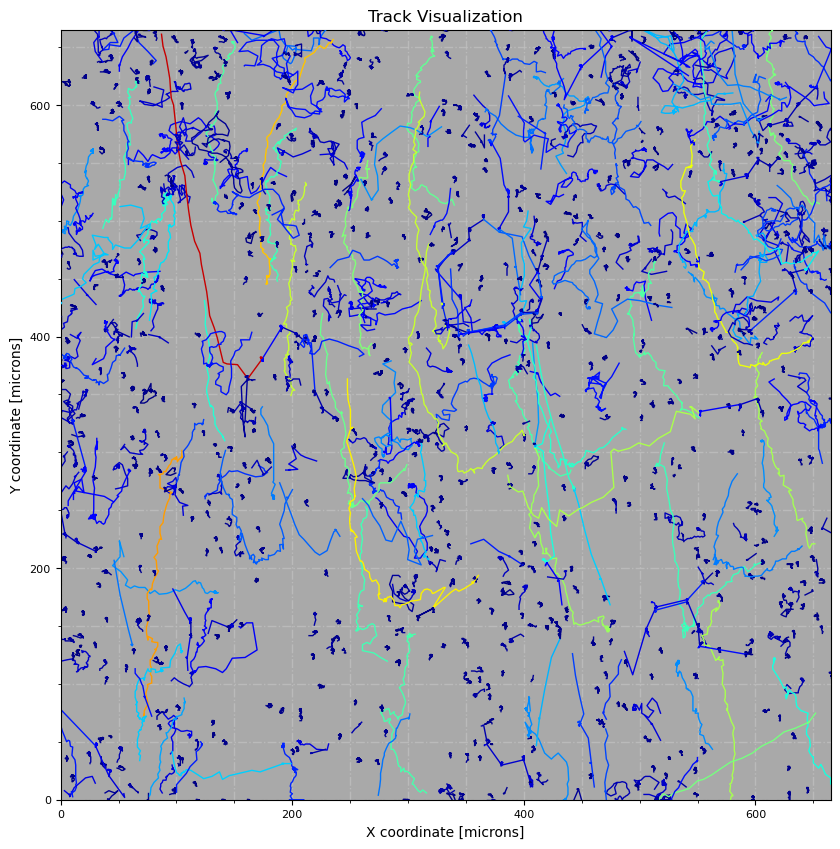

In [133]:
Visualize_tracks_matplotlib(
    Spots_df=spot_df_intconds, 
    Tracks_df=track_df_intconds,
    condition=2,
    replicate='all',
    c_mode='jet LUT',
    # smoothing_index=5,
)

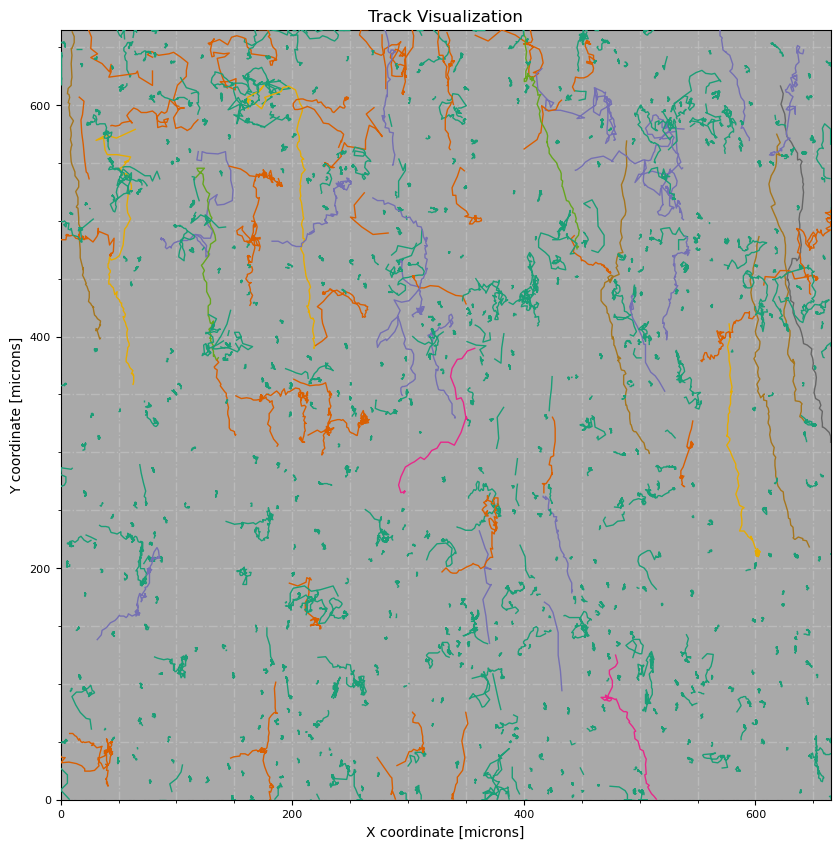

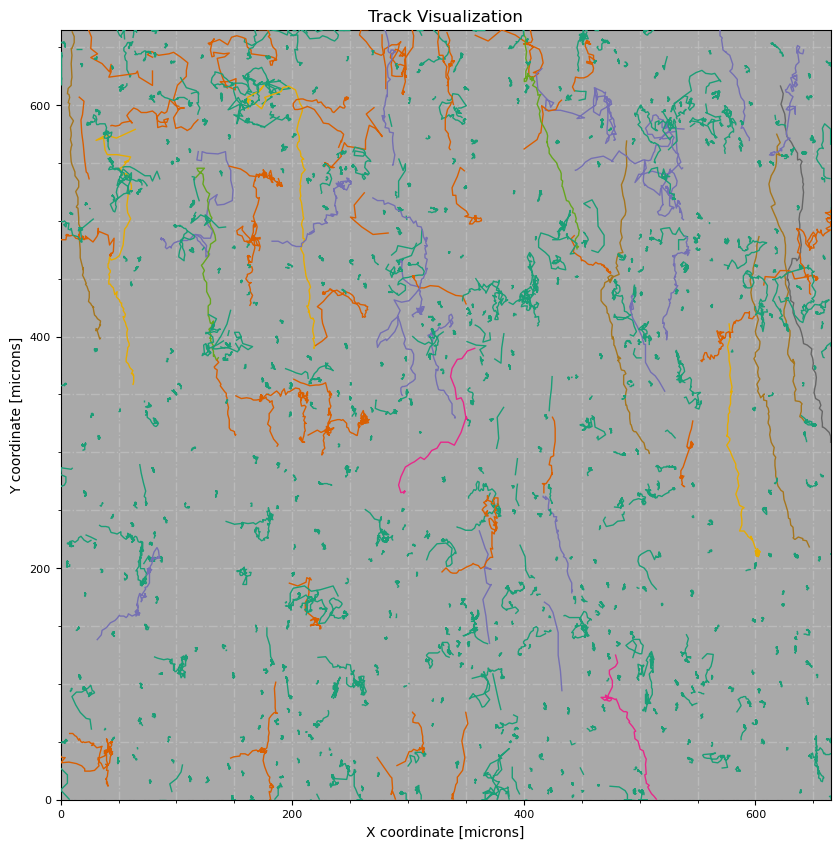

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def visualize_tracks_fast(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    *,
    condition: str | int = 'all',
    replicate: str | int = 'all',
    c_mode: str = 'random colors',              # 'random colors' | 'random greys' | 'only-one-color' |
                                                 # 'differentiate conditions' | 'differentiate replicates' | <matplotlib cmap name>
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    background: str = 'dark',
    smoothing_index: int | float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    arrows: bool = False,
    arrowsize: float = 1.0,
):
    # --- Early outs / guards -------------------------------------------------
    if not show_tracks:
        lw = 0

    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()

    # # Try to coerce condition/replicate to int if they look numeric
    # for name, val in (("condition", condition), ("replicate", replicate)):
    #     try:
    #         if val not in (None, 'all'):
    #             locals()[name] = int(val)
    #     except (ValueError, TypeError):
    #         pass

    # --- Filter & sort once ---------------------------------------------------
    required = ['Condition', 'Replicate', 'Track ID', 'Time point', 'X coordinate', 'Y coordinate']
    if any(col not in Spots.columns for col in required):
        return plt.gcf()

    if condition != 'all':
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
    if condition != 'all' and replicate != 'all':
        Spots = Spots.loc[Spots['Replicate'] == replicate]
        Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    Spots = Spots.sort_values(['Condition', 'Replicate', 'Track ID', 'Time point'])
    Tracks = Tracks.sort_values(['Condition', 'Replicate', 'Track ID'])

    # Ensure we can group efficiently
    key_cols = ['Condition', 'Replicate', 'Track ID']

    # Ensure keys exist only as index (no duplicate columns)
    Spots = Spots.set_index(key_cols, drop=True)      # drop=True is the default; keeps keys out of columns
    Tracks = Tracks.set_index(key_cols, drop=True)

    # if not isinstance(Spots.index, pd.MultiIndex) or Spots.index.names != key_cols:
    #     Spots = Spots.set_index(key_cols, drop=False)
    # if not isinstance(Tracks.index, pd.MultiIndex) or Tracks.index.names != key_cols:
    #     Tracks = Tracks.set_index(key_cols, drop=False)

    # --- Optional smoothing (vectorized) --------------------------------------
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        Spots['X coordinate'] = (
            Spots.groupby(level=key_cols)['X coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )
        Spots['Y coordinate'] = (
            Spots.groupby(level=key_cols)['Y coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )

    # --- Colors: compute once, map to each track ------------------------------
    rng = np.random.default_rng(42)

    def rand_color():
        return mcolors.to_hex(rng.random(3))
    def rand_grey():
        g = float(rng.random())
        return mcolors.to_hex((g, g, g))

    colormap = None
    if c_mode in ['random colors', 'random greys', 'only-one-color']:
        # one color per *track*
        unique_tracks = Tracks.index.unique()
        if c_mode == 'random colors':
            colors = [rand_color() for _ in range(len(unique_tracks))]
        elif c_mode == 'random greys':
            colors = [rand_grey() for _ in range(len(unique_tracks))]
        else:
            colors = [only_one_color] * len(unique_tracks)
        track_to_color = dict(zip(unique_tracks, colors))
        Tracks['Track color'] = [track_to_color[idx] for idx in Tracks.index]
    elif c_mode in ['differentiate conditions', 'differentiate replicates']:
        val_col = 'Condition' if c_mode == 'differentiate conditions' else 'Replicate'
        cmap = plt.get_cmap('Set1')
        uniq = pd.unique(Tracks[val_col])
        val_to_color = {v: mcolors.to_hex(cmap(i % cmap.N)) for i, v in enumerate(sorted(uniq))}
        Tracks['Track color'] = Tracks[val_col].map(val_to_color)
    else:
        # interpret c_mode as a matplotlib cmap name
        colormap = plt.get_cmap(c_mode)
        vmin = float(Tracks[lut_scaling_metric].min())
        vmax = float(Tracks[lut_scaling_metric].max())
        norm = plt.Normalize(vmin, vmax)
        Tracks['Track color'] = [mcolors.to_hex(colormap(norm(v))) for v in Tracks[lut_scaling_metric].to_numpy()]

    # Map per-track color down to Spots (single join; vectorized)
    # Replace the ambiguous join with this:
    Spots = Spots.join(
        Tracks[['Track color']],
        on=['Condition', 'Replicate', 'Track ID'],
        how='left',
        validate='many_to_one',
    )
    # --- Build line segments for LineCollection -------------------------------
    # Each segment is an array of shape (Ni, 2) for a track
    segments = []
    seg_colors = []
    # Using groupby over MultiIndex is still C-optimized; the loop is per-track (not per-point)
    for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
        xy = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
        if xy.shape[0] >= 2:
            segments.append(xy)
            seg_colors.append(g['Track color'].iloc[0])

    # --- Figure / axes setup ---------------------------------------------------
    if background == 'light':
        grid_color, face_color, grid_alpha, grid_ls = 'gainsboro', 'white', 0.5, '-.' if grid else 'None'
    else:
        grid_color, face_color, grid_alpha, grid_ls = 'silver', 'darkgrey', 0.75, '-.' if grid else 'None'

    fig, ax = plt.subplots(figsize=(13, 10))
    if len(Spots):
        x = Spots['X coordinate'].to_numpy()
        y = Spots['Y coordinate'].to_numpy()
        ax.set_xlim(np.nanmin(x), np.nanmax(x))
        ax.set_ylim(np.nanmin(y), np.nanmax(y))

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X coordinate [microns]')
    ax.set_ylabel('Y coordinate [microns]')
    ax.set_title('Track Visualization', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(grid, which='both', axis='both', color=grid_color, linestyle=grid_ls, linewidth=1, alpha=grid_alpha)

    # Ticks: use Locators/Formatters instead of setting ticklabels manually
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(axis='both', which='major', labelsize=8)

    # --- Draw all tracks at once ----------------------------------------------
    if segments:
        lc = LineCollection(segments, colors=seg_colors, linewidths=lw, zorder=10)
        ax.add_collection(lc)

    # --- Optional arrows (use quiver in one batch) ----------------------------
    if arrows:
        # Take the last two points of each track to estimate direction
        tails_x, tails_y, dxs, dys, c_arr = [], [], [], [], []
        # Vectorized-ish: one pass per track (still cheap)
        for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
            arr = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
            if arr.shape[0] >= 2:
                x0, y0 = arr[-2]
                x1, y1 = arr[-1]
                dx, dy = x1 - x0, y1 - y0
                tails_x.append(x0); tails_y.append(y0)
                dxs.append(dx); dys.append(dy)
                c_arr.append(g['Track color'].iloc[0])
        if tails_x:
            # Matplotlib quiver supports a single color or an array mapped via a colormap.
            # We add multiple quivers in chunks to preserve per-arrow colors efficiently.
            # (One large call per unique color is still fast.)
            tails_x = np.array(tails_x); tails_y = np.array(tails_y)
            dxs = np.array(dxs); dys = np.array(dys)
            c_arr = np.array(c_arr)
            for col in np.unique(c_arr):
                mask = c_arr == col
                ax.quiver(
                    tails_x[mask], tails_y[mask], dxs[mask], dys[mask],
                    angles='xy', scale_units='xy', scale=1,
                    width=0.003 * arrowsize, headlength=5*arrowsize, headaxislength=4*arrowsize, headwidth=4*arrowsize,
                    color=col, zorder=30
                )

    return fig

visualize_tracks_fast(
    Spots_df=spot_df_intconds, 
    Tracks_df=track_df_intconds,
    condition=1,
    replicate='all',
    c_mode='Dark2',
    # smoothing_index=5,
)

In [156]:
def _get_cmap(c_mode):
    c_mode = c_mode.replace("nipy-spectral", "nipy_spectral")
    if c_mode == 'greyscale LUT': return plt.cm.gist_yarg
    elif c_mode == 'jet LUT': return plt.cm.jet
    elif c_mode == 'brg LUT': return plt.cm.brg
    elif c_mode == 'hot LUT': return plt.cm.hot
    elif c_mode == 'gnuplot LUT': return plt.cm.gnuplot
    elif c_mode == 'viridis LUT': return plt.cm.viridis
    elif c_mode == 'rainbow LUT': return plt.cm.rainbow
    elif c_mode == 'turbo LUT': return plt.cm.turbo
    elif c_mode == 'nipy_spectral LUT': return plt.cm.nipy_spectral
    elif c_mode == 'gist-ncar LUT': return plt.cm.gist_ncar
    else: return None


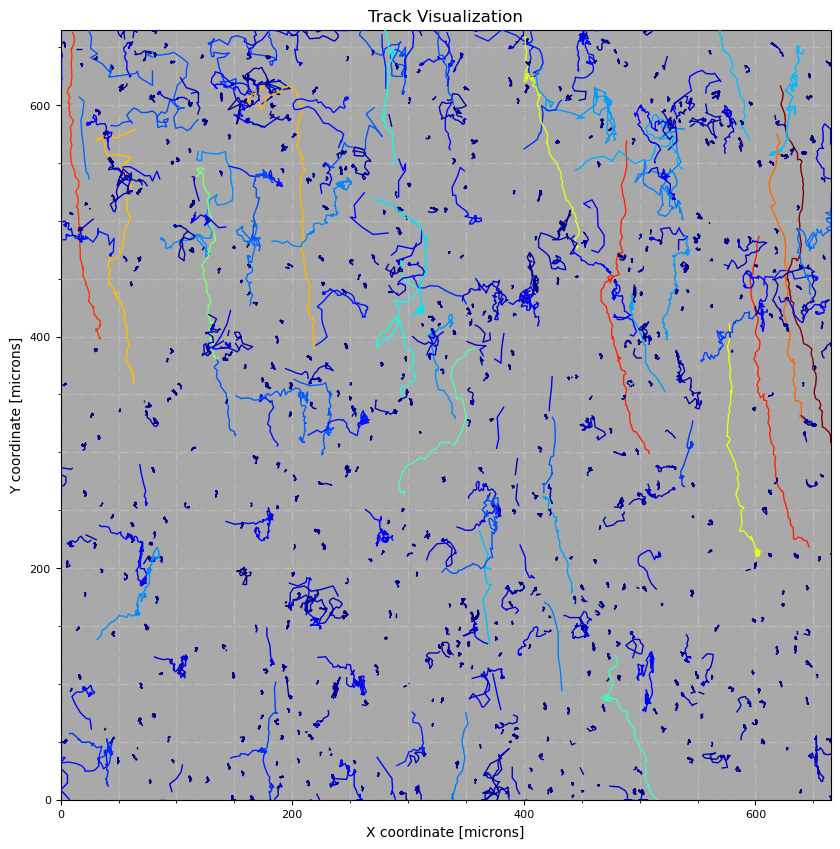

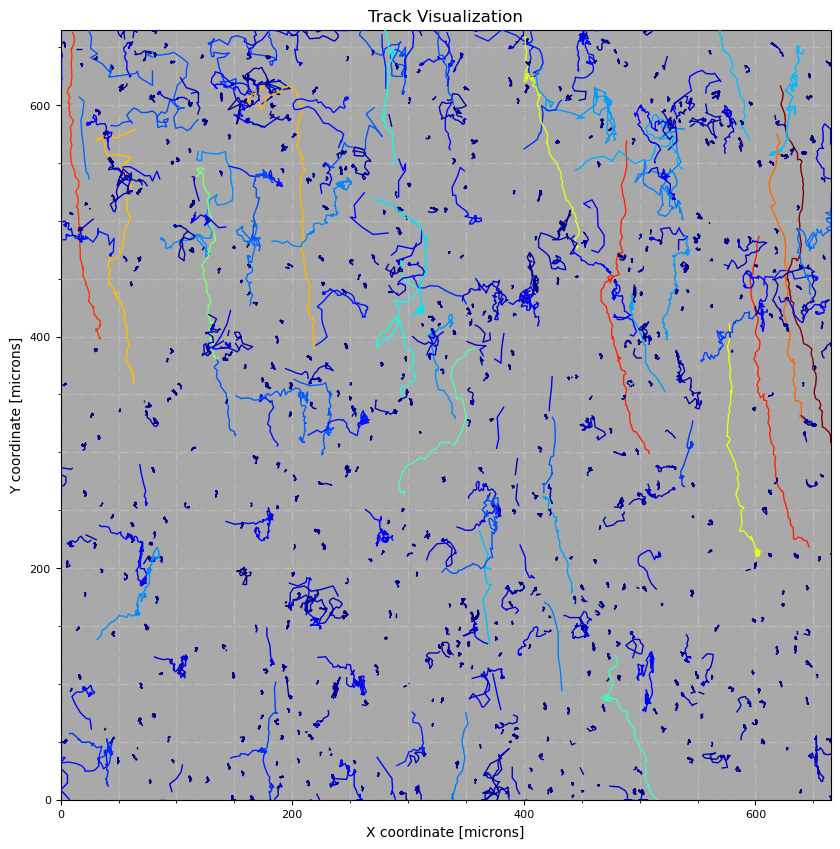

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def visualize_tracks_fast(
    Spots_df: pd.DataFrame,
    Tracks_df: pd.DataFrame,
    *,
    condition: str | int = 'all',
    replicate: str | int = 'all',
    c_mode: str = 'random colors',              # 'random colors' | 'random greys' | 'only-one-color' |
                                                 # 'differentiate conditions' | 'differentiate replicates' | <matplotlib cmap name>
    only_one_color: str = 'blue',
    lut_scaling_metric: str = 'Track displacement',
    background: str = 'dark',
    smoothing_index: int | float = 0,
    lw: float = 1.0,
    show_tracks: bool = True,
    grid: bool = True,
    arrows: bool = False,
    arrowsize: float = 1.0,
):
    # --- Early outs / guards -------------------------------------------------
    if not show_tracks:
        lw = 0

    Spots = Spots_df.copy()
    Tracks = Tracks_df.copy()

    # # Try to coerce condition/replicate to int if they look numeric
    # for name, val in (("condition", condition), ("replicate", replicate)):
    #     try:
    #         if val not in (None, 'all'):
    #             locals()[name] = int(val)
    #     except (ValueError, TypeError):
    #         pass

    # --- Filter & sort once ---------------------------------------------------
    required = ['Condition', 'Replicate', 'Track ID', 'Time point', 'X coordinate', 'Y coordinate']
    if any(col not in Spots.columns for col in required):
        return plt.gcf()

    if condition != 'all':
        Spots = Spots.loc[Spots['Condition'] == condition]
        Tracks = Tracks.loc[Tracks['Condition'] == condition]
    if condition != 'all' and replicate != 'all':
        Spots = Spots.loc[Spots['Replicate'] == replicate]
        Tracks = Tracks.loc[Tracks['Replicate'] == replicate]

    Spots = Spots.sort_values(['Condition', 'Replicate', 'Track ID', 'Time point'])
    Tracks = Tracks.sort_values(['Condition', 'Replicate', 'Track ID'])

    # Ensure we can group efficiently
    key_cols = ['Condition', 'Replicate', 'Track ID']

    # Ensure keys exist only as index (no duplicate columns)
    Spots = Spots.set_index(key_cols, drop=True)      # drop=True is the default; keeps keys out of columns
    Tracks = Tracks.set_index(key_cols, drop=True)

    # if not isinstance(Spots.index, pd.MultiIndex) or Spots.index.names != key_cols:
    #     Spots = Spots.set_index(key_cols, drop=False)
    # if not isinstance(Tracks.index, pd.MultiIndex) or Tracks.index.names != key_cols:
    #     Tracks = Tracks.set_index(key_cols, drop=False)

    # --- Optional smoothing (vectorized) --------------------------------------
    if isinstance(smoothing_index, (int, float)) and smoothing_index > 1:
        win = int(smoothing_index)
        Spots['X coordinate'] = (
            Spots.groupby(level=key_cols)['X coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )
        Spots['Y coordinate'] = (
            Spots.groupby(level=key_cols)['Y coordinate'].transform(lambda s: s.rolling(win, min_periods=1).mean())
        )

    # --- Colors: compute once, map to each track ------------------------------
    rng = np.random.default_rng(42)

    def rand_color():
        return mcolors.to_hex(rng.random(3))
    def rand_grey():
        g = float(rng.random())
        return mcolors.to_hex((g, g, g))

    # --- Colors: compute once, map to each track ------------------------------
    # Accept both '-' and '_' variants for nipy spectral
    rng = np.random.default_rng(42)

    colormap = None
    mode = c_mode  # keep original name

    # 1) Random & single-color (qualitative, 1 color per track)
    if mode in ["random colors", "random greys", "only-one-color"]:
        unique_tracks = Tracks.index.unique()
        if mode == "random colors":
            colors = [_generate_random_color() for _ in range(len(unique_tracks))]
        elif mode == "random greys":
            colors = [_generate_random_grey() for _ in range(len(unique_tracks))]
        else:  # only-one-color
            colors = [only_one_color] * len(unique_tracks)
        track_to_color = dict(zip(unique_tracks, colors))
        Tracks["Track color"] = [track_to_color[idx] for idx in Tracks.index]

    # 2) Differentiate conditions/replicates (qualitative, category → color)
    elif mode == "differentiate conditions/replicates":
        # Heuristic: if a single condition is selected (condition != 'all'), use Replicate; otherwise Condition
        if condition != "all":
            val_col = "Replicate"
        else:
            val_col = "Condition"
        # Use Set1 (nice qualitative palette); wrap if categories exceed palette size
        cmap = plt.get_cmap("Set1")
        uniq_vals = pd.unique(Tracks[val_col])
        # Stable ordering for reproducibility
        val_to_color = {v: mcolors.to_hex(cmap(i % cmap.N)) for i, v in enumerate(sorted(uniq_vals))}
        Tracks["Track color"] = Tracks[val_col].map(val_to_color)

    # 3) LUT (quantitative, scale by lut_scaling_metric)
    elif mode in [
        "greyscale LUT", "jet LUT", "brg LUT", "hot LUT", "gnuplot LUT",
        "viridis LUT", "rainbow LUT", "turbo LUT", "nipy-spectral LUT", "gist-ncar LUT",
    ]:
        colormap = _get_cmap(mode)
        if lut_scaling_metric not in Tracks.columns:
            raise KeyError(
                f"lut_scaling_metric '{lut_scaling_metric}' not found in Tracks_df columns: {list(Tracks.columns)}"
            )
        vmin = float(Tracks[lut_scaling_metric].min())
        vmax = float(Tracks[lut_scaling_metric].max())
        # Avoid zero-range norm
        if np.isclose(vmin, vmax):
            vmax = vmin + 1e-12
        norm = plt.Normalize(vmin, vmax)
        Tracks["Track color"] = [
            mcolors.to_hex(colormap(norm(v))) for v in Tracks[lut_scaling_metric].to_numpy()
        ]

    # 4) Fall back: if user passed a direct Matplotlib cmap name (e.g., "Dark2")
    else:
        try:
            colormap = plt.get_cmap(mode)
            # If it's a qualitative cmap, color per-category; if you want metric scaling, stick to the LUT modes above.
            # Here we do per-track assignment cycling through the cmap.
            unique_tracks = Tracks.index.unique()
            n = len(unique_tracks)
            colors = [mcolors.to_hex(colormap(i / max(n, 1))) for i in range(n)]
            track_to_color = dict(zip(unique_tracks, colors))
            Tracks["Track color"] = [track_to_color[idx] for idx in Tracks.index]
        except ValueError:
            raise ValueError(
                f"Unknown color mode '{mode}'. Expected one of {['random colors','random greys','differentiate conditions/replicates','only-one-color'] + ['<...> LUT'] + ['<matplotlib cmap name>']}"
            )

    # Map per-track color down to Spots (fast join by index; you already set MultiIndex above)
    Spots = Spots.join(Tracks[["Track color"]], how="left")

    # --- Build line segments for LineCollection -------------------------------
    # Each segment is an array of shape (Ni, 2) for a track
    segments = []
    seg_colors = []
    # Using groupby over MultiIndex is still C-optimized; the loop is per-track (not per-point)
    for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
        xy = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
        if xy.shape[0] >= 2:
            segments.append(xy)
            seg_colors.append(g['Track color'].iloc[0])

    # --- Figure / axes setup ---------------------------------------------------
    if background == 'light':
        grid_color, face_color, grid_alpha, grid_ls = 'gainsboro', 'white', 0.5, '-.' if grid else 'None'
    else:
        grid_color, face_color, grid_alpha, grid_ls = 'silver', 'darkgrey', 0.75, '-.' if grid else 'None'

    fig, ax = plt.subplots(figsize=(13, 10))
    if len(Spots):
        x = Spots['X coordinate'].to_numpy()
        y = Spots['Y coordinate'].to_numpy()
        ax.set_xlim(np.nanmin(x), np.nanmax(x))
        ax.set_ylim(np.nanmin(y), np.nanmax(y))

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X coordinate [microns]')
    ax.set_ylabel('Y coordinate [microns]')
    ax.set_title('Track Visualization', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(grid, which='both', axis='both', color=grid_color, linestyle=grid_ls, linewidth=1, alpha=grid_alpha)

    # Ticks: use Locators/Formatters instead of setting ticklabels manually
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(axis='both', which='major', labelsize=8)

    # --- Draw all tracks at once ----------------------------------------------
    if segments:
        lc = LineCollection(segments, colors=seg_colors, linewidths=lw, zorder=10)
        ax.add_collection(lc)

    # --- Optional arrows (use quiver in one batch) ----------------------------
    if arrows:
        # Take the last two points of each track to estimate direction
        tails_x, tails_y, dxs, dys, c_arr = [], [], [], [], []
        # Vectorized-ish: one pass per track (still cheap)
        for (cond, repl, tid), g in Spots.groupby(level=key_cols, sort=False):
            arr = g[['X coordinate', 'Y coordinate']].to_numpy(dtype=float, copy=False)
            if arr.shape[0] >= 2:
                x0, y0 = arr[-2]
                x1, y1 = arr[-1]
                dx, dy = x1 - x0, y1 - y0
                tails_x.append(x0); tails_y.append(y0)
                dxs.append(dx); dys.append(dy)
                c_arr.append(g['Track color'].iloc[0])
        if tails_x:
            # Matplotlib quiver supports a single color or an array mapped via a colormap.
            # We add multiple quivers in chunks to preserve per-arrow colors efficiently.
            # (One large call per unique color is still fast.)
            tails_x = np.array(tails_x); tails_y = np.array(tails_y)
            dxs = np.array(dxs); dys = np.array(dys)
            c_arr = np.array(c_arr)
            for col in np.unique(c_arr):
                mask = c_arr == col
                ax.quiver(
                    tails_x[mask], tails_y[mask], dxs[mask], dys[mask],
                    angles='xy', scale_units='xy', scale=1,
                    width=0.003 * arrowsize, headlength=5*arrowsize, headaxislength=4*arrowsize, headwidth=4*arrowsize,
                    color=col, zorder=30
                )

    return fig

visualize_tracks_fast(
    Spots_df=spot_df_intconds, 
    Tracks_df=track_df_intconds,
    condition=1,
    replicate='all',
    c_mode='jet LUT',
    # smoothing_index=5,
)